# Analysis of SEIRX model runs for test technology and screening frequency

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl

### Utility functions for plotting

In [11]:
def get_image(df, subset, metric):
    subset = df.loc[subset]
    img = np.zeros((4,4))
    screening_intervals = ['none', 'once\na week', 'every\n3 days', 'every\n2 days']
    for i, p_index in enumerate(screening_intervals):
        for j, e_index in enumerate(screening_intervals):
            img[i, j] = subset.loc[p_index, e_index][metric]
    return img

def plot_heatmap_turnover_time(ax, img, vmin, vmax, xticks, yticks):
    cmap = plt.get_cmap('coolwarm')
    im = ax.imshow(img, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
    
    if xticks:
        ax.set_xticks(range(len(screening_intervals)))
        ax.set_xticklabels(screening_intervals, fontsize=9)
        ax.set_xlabel('screening frequency employees', fontsize=12)
    else:
        ax.set_xticks([])
    if yticks:    
        ax.set_yticks(range(len(screening_intervals)))
        ax.set_yticklabels(screening_intervals, fontsize=9)
        ax.set_ylabel('screening frequency residents', fontsize=12)
    else:
        ax.set_yticks([])
    
    return im

def annotate_heatmap(ax, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y_pos = i - 0.05
            x_pos = j - 0.15
            ax.text(x_pos, y_pos, '{:1.2f}'.format(img[i, j]))

### Mappings of variables to nicer labels for plots

In [12]:
frequency_name_map = {np.nan:'none',
              2:'every\n2 days',
              3:'every\n3 days',
              7:'once\na week'}

test_name_map = {'same_day_antigen':'same-day antigen', 'one_day_PCR':'one day PCR',
             'two_day_PCR':'two days PCR', 'same_day_PCR':'same-day PCR',
             'same_day_LAMP':'same-day RT-LAMP'}

metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                   'infected_residents_median':'follow-up cases residends (median)',
                   'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                   'R0_mean':'$R_0$',
                   'R0_mean':'$R_0$'}

index_case_map = {'employee':'index case employee',
                  'resident':'index case resident'}

screening_intervals = ['none', 'once\na week', 'every\n3 days', 'every\n2 days']

### Data loating and wrangling

In [13]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_test_technology_screening_interval'
data = pd.read_csv(join(res_path,'{}.csv'.format(sim_name)))

In [14]:
# calculate the mean overall number of tests used as sum of all
# diagnostic and preventive screening tests
data['N_tests_mean'] = data['N_diagnostic_tests_mean'] +\
    data['N_preventive_tests_mean']

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set a multi-index to facilitate access to different scenarios that were simulated
tuples = [(r['test_type'], r['resident_screen_interval'],\
           r['employee_screen_interval']) for i,r in data.iterrows()]
index = pd.MultiIndex.from_tuples(tuples,\
    names=['test_type', 'resident_screen_interval', 'employee_screen_interval'])
data = data.set_index(index)

In [15]:
data['infected_residents_0.90']

test_type         resident_screen_interval  employee_screen_interval
same_day_antigen  every\n3 days             once\na week                8.0
                                            every\n2 days               7.0
                  every\n2 days             every\n2 days               7.0
                  once\na week              every\n2 days               8.0
                                            once\na week                8.0
                                                                       ... 
two_day_PCR       every\n2 days             none                        6.0
                  none                      once\na week                9.0
                  every\n3 days             none                        7.0
                  once\na week              none                        8.0
                  none                      none                        9.0
Name: infected_residents_0.90, Length: 160, dtype: float64

## Different test technologies

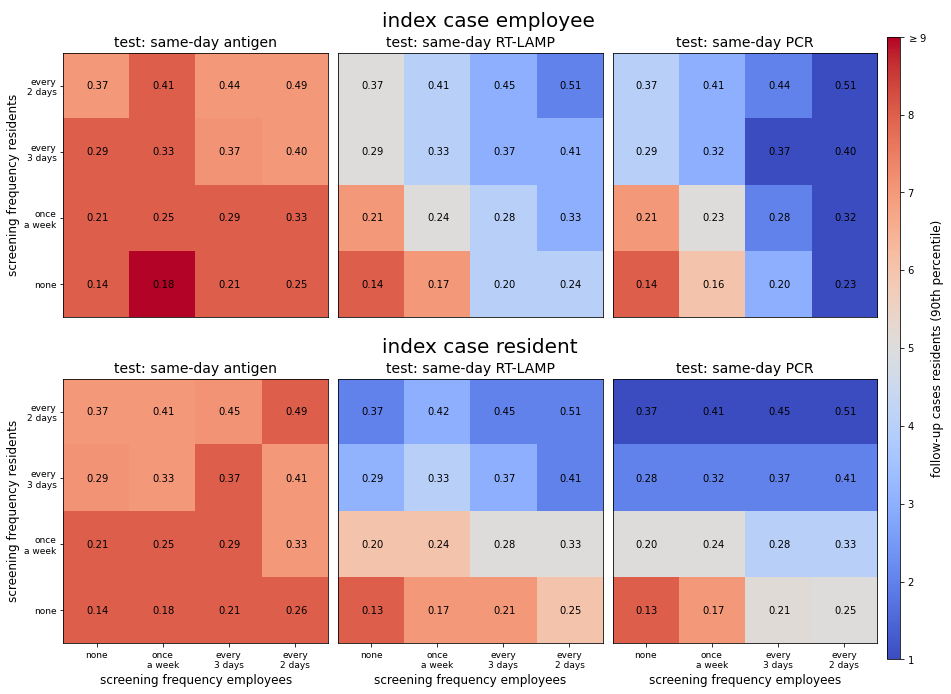

In [20]:
metric = 'infected_residents_0.90'
sim_name = 'simulation_results'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=1
vmax=9
vstep=1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data[data['index_case'] == index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = get_image(df, test_type, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = plot_heatmap_turnover_time(ax,img,vmin,vmax,xticks,yticks)
        
        # annotate heatmap with tests / days / agent
        tests_per_agent = get_image(df, test_type, 'N_tests_mean') / (35+18)
        duration = get_image(df,test_type, 'duration_mean')
        tests_per_agent_per_day = tests_per_agent / duration
        annotate_heatmap(ax, tests_per_agent_per_day)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_test_technology.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_test_technology.pdf'))

## PCR: different turnover times

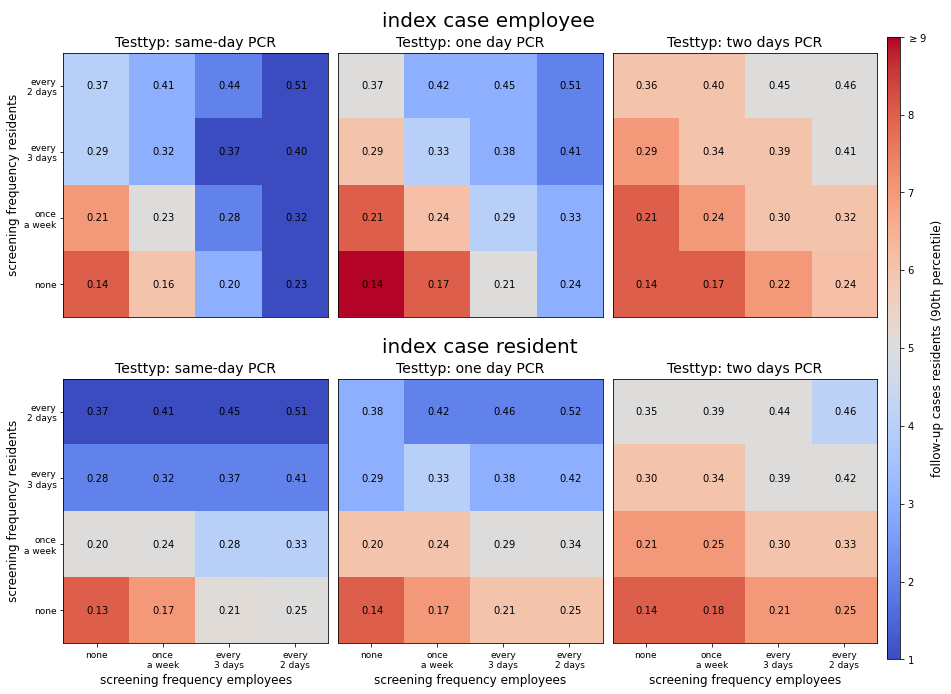

In [22]:
metric = 'infected_residents_0.90'
sim_name = 'simulation:results'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 1
vmax = 9
tickstep = 1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data[data['index_case'] == index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Testtyp: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = get_image(df, test_type, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = plot_heatmap_turnover_time(ax, img, vmin, vmax, xticks, yticks)
        
        # annotate heatmap with tests / days / agent
        tests_per_agent = get_image(df, test_type, 'N_tests_mean') / (35+18)
        duration = get_image(df,test_type, 'duration_mean')
        tests_per_agent_per_day = tests_per_agent / duration
        annotate_heatmap(ax, tests_per_agent_per_day)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, tickstep))
yticklabels = list(range(vmin, vmax)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.pdf'))